# (3) Plot Tide Distributions for XYT

**Author:** Bryony Freer

**Date Published:** 31 May 2023

This notebook: 
1. Extracts time series' of tide heights and gradients experienced across a single year (centred on 1 Jan 2020) in the study region, from the CATS2008a tide model. 
2. Plots range of sampled tides per ICESat-2 RGT over the histogram of annual tide height distributions in the region. This highlights the range of tides that has been sampled by ICESat-2 along each RGT during the study period.


### Inputs:
* ***used_cycles.csv*** (output of ATL06_PlotRepeatTracks notebook)
* ***used-rgts-and-lowest-tide-info.csv*** (output of ATL06_PlotRepeatTracks notebook)
* ***tide_calculation_locations.csv***
* ***CATS2008 tide model*** ( Install/download here https://pytmd.readthedocs.io/en/latest/getting_started/Install.html)


### Outputs:

This script outputs ***Track{rgt}_TideInfo.csv*** for each RGT, recording for each cycle:
* 'rgt'
* 'cyc'
* 'rgt_cyc' (unique identifier combining RGT and cyc number, eg 1016_05)
* 'tide_h' (tide amplitude, m)
* 'tide_grad' (tide gradient, cm/min)
* 'pc_above' (percentage of total tide range above the sampled tide)
* 'pc_below' (percentage of total tide range below the sampled tide)
* 'tide_x' (x coord of location used to calculate tides)
* 'tide_y' (y coord of location used to calculate tides)



### References
Howard, S. L., Padman, L., and Erofeeva, S. Y.: CATS2008: Circum-Antarctic Tidal Simulation version 2008 (1), https://doi.org/10.15784/601235, 2019.

T. C. Sutterley, K. Alley, K. Brunt, S. Howard, L. Padman, and M. Siegfried, “pyTMD: Python-based tidal prediction software”, (2017). doi: 10.5281/zenodo.5555395


In [1]:
# Imports 
from __future__ import print_function

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import ipywidgets as widgets
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import r2_score

import datetime as dt
from datetime import datetime 
import glob

import pyTMD.time
from pyTMD.calc_delta_time import calc_delta_time
from pyTMD.infer_minor_corrections import infer_minor_corrections
from pyTMD.predict_tidal_ts import predict_tidal_ts
from pyTMD.read_tide_model import extract_tidal_constants
from pyTMD.read_netcdf_model import extract_netcdf_constants
from pyTMD.read_GOT_model import extract_GOT_constants
from pyTMD.read_FES_model import extract_FES_constants
from pyTMD.compute_tide_corrections import compute_tide_corrections
#-- autoreload
%load_ext autoreload
%autoreload 2

def create_color_dict():
    return {3:'#1f77b4', 4: '#ff7f0e', 5: '#2ca02c', 6: '#d62728', 7: '#9467bd', 8: '#8c564b', 9: '#e377c2', 10: '#7f7f7f', 11:'#bcbd22', 12: '#17becf', 13:'#6b2472', 14:'#55FF55', 15:'#f53b92', 16: '#2D2B83', 17:'#FBFF00'}

In [40]:
#1. SET DIRECTORIES 

# USER INPUT: Specify paths to folder containing ATL06 files
region = 'FRIS' 
root = f'../sample_data/{region}/'
atl06_dir = root + 'data/' 
outdir = root + 'results/'
cycles_dir = root + 'results/used_cycles/'

# Set the directory containing the CATS2008 tide model
tide_dir = root + '/tide_models'
TIDE_MODEL = 'CATS2008'

# Set font info and consistent colour dictionary for IS2 cycles
color_dict = create_color_dict()
SMALL= 14
MED = 18
LARGE = 22
plt.rc('font', size=SMALL)          # controls default text sizes
plt.rc('axes', titlesize=SMALL)     # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

In [47]:
#2. DEFINE LOCATION FOR TIDE CALCULATION 

# Read in csv of locations for tide calculation (W, C and E)
df = pd.read_csv(root + 'tide_calculation_locations.csv', index_col='location')

#Set which location for tide calculation 
tide_loc = 'E' #Options: 'W', 'C' or 'E'

LAT = df.loc[tide_loc]['lat']
LON = df.loc[tide_loc]['lon']
x = df.loc[tide_loc]['x']
y = df.loc[tide_loc]['y']
print(f'Selected Tide Location: {tide_loc}\nLat/Lon:{LAT}, {LON}\nXY:{x}, {y}')

Selected Tide Location: E
Lat/Lon:-81.254, -62.868
XY:-847283.992, 434174.425


## 1. Set up tide model and functions

Uses the LAT/LON and x/y locations defined above. 

In [49]:
#-- select tide model (CATS2008)
grid_file = os.path.join(tide_dir,'CATS2008','grid_CATS2008')
model_file = os.path.join(tide_dir,'CATS2008','hf.CATS2008.out')
reference = ('https://www.esr.org/research/polar-tide-models/'
    'list-of-polar-tide-models/cats2008/')
model_format = 'OTIS'
EPSG = 'CATS2008'
TYPE = 'z'

#-- read tidal constants and interpolate to grid points (CATS2008 in OTIS format)
amp,ph,D,c = extract_tidal_constants(np.array([LON]), np.array([LAT]),
    grid_file,model_file,EPSG,TYPE=TYPE,METHOD='spline',GRID=model_format)

#-- calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
#-- calculate constituent oscillation
hc = amp*np.exp(cph)

def find_nearest_idx(array, value):
    '''Returns index of value in input array closest to the input value.'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def CalcOneYearTides(x,y, epoch=dt.datetime(2000,1,1,0,0,0)):
    
    '''Function to calculate one year of tide heights (per minute) in single XY location.'''
    
    #Set values for compute_tide_corrections
    x_np = np.full((1,),x)  #xy have to be converted to numpy arrays
    y_np = np.full((1,),y)

    # Create numpy array of one year in minutes (mid 2019 to mid 2020)
    ## a) Set centre date (here Jan 01 2020)
    dt2020 = dt.datetime(2020,1,1,1,1,1)
    ## b) One Julian year has 365 days (so create array of 182 days * 1440 minutes either side of 1 Jan 2020)
    tide_time = pyTMD.time.convert_calendar_dates(dt2020.year, dt2020.month,dt2020.day, dt2020.hour, minute=np.arange((-182 * 1440),(182 * 1440)+1))

    #-- convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
    #-- predict tidal elevations at time 1 and infer minor corrections
    deltat = np.zeros_like(tide_time)
    TIDE = predict_tidal_ts(tide_time, hc, c,DELTAT=deltat, CORRECTIONS=model_format)
    MINOR = infer_minor_corrections(tide_time, hc, c,DELTAT=deltat, CORRECTIONS=model_format)
    TIDE.data[:] += MINOR.data[:]
    
    return TIDE, tide_time

## 2. Calculate one year of tide heights
Centered on 01/01/2020. Location uses LAT/LON x/y location defined above. 

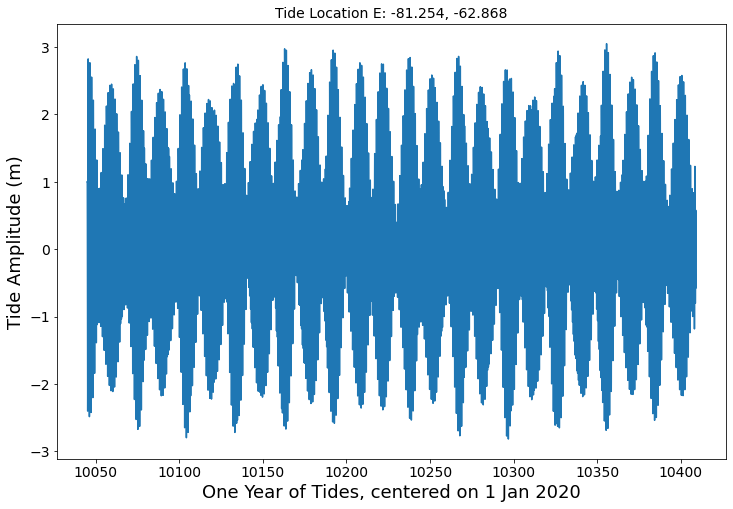

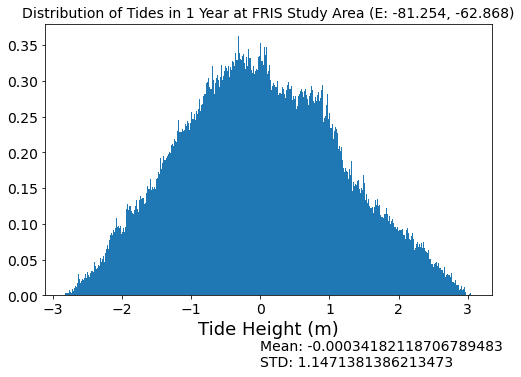

In [50]:
plot_ts = True
plot_hist = True
save_fig = False

#Call function to generate one year time series of tides at XY location 
TIDE, TIDE_times = CalcOneYearTides(x,y)

#Plot time series of tides for one year at XY location 
if plot_ts == True: 
    plt.figure(figsize=[12,8])
    plt.plot(TIDE_times, TIDE.data)
    plt.ylabel('Tide Amplitude (m)')
    plt.xlabel('One Year of Tides, centered on 1 Jan 2020')
    plt.title(f'Tide Location {tide_loc}: {LAT}, {LON}')
    if save_fig == True:
        plt.savefig(outdir + f'tide_1yrtimeseries_{region}_{tide_loc}', bbox_inches='tight', dpi=300)
        
if plot_hist == True:
    plt.figure(figsize=[8,5]) 
    plt.hist(TIDE.data, bins=500, density=True)
    plt.xlabel('Tide Height (m)')
    plt.title(f'Distribution of Tides in 1 Year at {region} Study Area ({tide_loc}: {LAT}, {LON})')

    #Calculate mean tide and std for the year of tides, and add to figure 
    tide_mean = np.mean(TIDE.data)
    tide_std = np.std(TIDE.data)
    plt.text(x=0, y=-0.1, s=f'Mean: {tide_mean}\nSTD: {tide_std}')
    if save_fig == True:
        plt.savefig(outdir + f'tide_1yrhist_{region}_{tide_loc}', bbox_inches='tight', dpi=300)

## 3. Calculate tide amplitude + gradient at each cycle per RGT


In [55]:
#1: Define list of RGTs 

# Read in CSV of used RGTs 
rgts_df = pd.read_csv(root + 'used-rgts-and-lowest-tide-info.csv', index_col='rgt')

# Option 1: Use all RGTs 
#rgts = [str(x).zfill(4) for x in rgts_df.index.values]

# Option 2: Filter RGT list by tide location (W/C/E)
#rgts = rgts_df[rgts_df['tide_location']==tide_loc].index.tolist()
#rgts = [str(x).zfill(4) for x in rgts]

# Option 3: Manually specify RGT(s) in list
rgts = ['0559']

RGT  0559
04
06
08
09
11
12
13


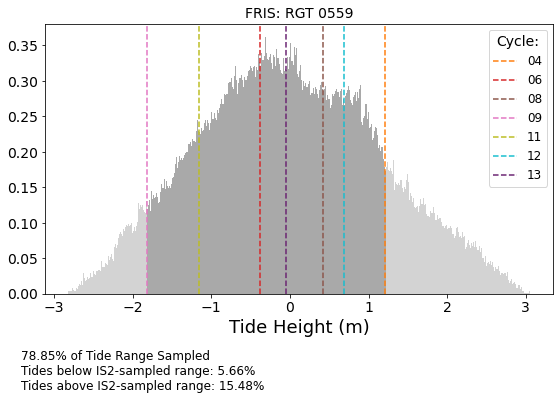

In [56]:
#2. Calculate tide amplitudes and gradients

export_csv = False
plot_fig = True 
save_fig = False

for rgt in rgts:
    #if rgt in []: #Optional: set list of rgts to ignore (unhash to use)
        #continue
    print('RGT ', rgt)
    #1. Initiate dictionaries to store values 
    tide_amps = {}
    tide_gradients = {}
    
    #2. Identify used cycles
    if os.path.isfile(f'{cycles_dir}/used_cycles_{rgt}.txt'):
        used_cycles = []
        # open file and read the content in a list
        with open(f'{cycles_dir}/used_cycles_{rgt}.txt', 'r') as filehandle:
            for line in filehandle:
                cycle = line[:-1]
                used_cycles.append(cycle)
    else:
        print('Used Cycles txt file has not been generated yet.')
    
    # Option to manually add individual cycles:
    #used_cycles += ['03']
    
    #3. Loop through cycles to extract tide amps and gradients 
    for filename in glob.glob(os.path.join(atl06_dir, f'*processed_ATL06_*_{rgt}*.h5')):
        cycle = filename[-14:-12]        
        if cycle in used_cycles:
            print(cycle)
            #extract track date/time per cycle and convert to format needed for tide model
            dt_str = filename[-33:-19]
            indices = [0,4,6,8,10,12]
            yr,m,d,h,mi,s = [int(dt_str[i:j]) for i,j in zip(indices, indices[1:]+[None])]
            track_time = dt.datetime(yr,m,d,h,mi,s)
            #create array of tide times at the track time +- one minute
            tide_time = pyTMD.time.convert_calendar_dates(track_time.year, track_time.month,
                        track_time.day, track_time.hour, minute=(track_time.minute + np.arange(-1,2)))
            #Create track time in format same as tide times used in pyTMD
            track_time_cal = pyTMD.time.convert_calendar_dates(track_time.year, track_time.month, track_time.day, track_time.hour, track_time.minute, track_time.second)

            #-- convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
            #-- predict tidal elevations at time 1 and infer minor corrections
            deltat = np.zeros_like(tide_time)
            TIDE_TS = predict_tidal_ts(tide_time, hc, c,DELTAT=deltat, CORRECTIONS=model_format)
            MINOR = infer_minor_corrections(tide_time, hc, c,DELTAT=deltat, CORRECTIONS=model_format)
            TIDE_TS.data[:] += MINOR.data[:]

            #Calculate gradient of tide at each point in array 
            gradients = np.gradient(TIDE_TS.data)*100 #convert m/min to cm/min
            track_idx =  find_nearest_idx(tide_time, track_time_cal)

            # Add the tide gradient at the index closest to the track time to the data dictionary
            tide_gradients[cycle] = gradients[track_idx]

            #Add the tide amplitude to dictionary 
            tide_amps[cycle] = TIDE_TS.data[1]#/100

            #print(f'RGT: {rgt}, Cycle {cycle}: \nTide Height: {TIDE.data[1]}\nTide Gradient', gradients[track_idx])
    
    #4. Extract min and max tides (and cycles) (NOTE - check whether I actually use these again... )
    track_tide_max = max(tide_amps.values())
    track_tide_max_c = max(tide_amps, key=tide_amps.get)
    track_tide_min = min(tide_amps.values())
    track_tide_min_c = min(tide_amps, key=tide_amps.get)

    #print(f'RGT {rgt}:\nMax: Cycle {track_tide_max_c}, {track_tide_max}\nMin: Cycle {track_tide_min_c}, {track_tide_min}')
    
    #5. EXPORT TIDE INFO TO CSV
    d={}
    idx=0
    for cyc,tide in tide_amps.items():
        idx+=1
        #Count the number of values in the TIDE array that are above / below the tide at each cycle  
        count_a = TIDE.data[TIDE.data>tide].shape[0]
        count_b = TIDE.data[TIDE.data<tide].shape[0]
        #Calculate % of tide values in annual tide record that are above / below the tide at each cycle
        pc_a = (count_a/TIDE.data.shape[0])*100
        pc_b = (count_b/TIDE.data.shape[0])*100
        rgt_cyc = rgt + '_' + cyc
        #extract tide gradient 
        tide_grad = tide_gradients[cyc]
        #Add to dictionary (along with other useful metatdata)
        d[idx] = (rgt, cyc, rgt_cyc, tide, tide_grad, pc_a, pc_b, x, y)

    #Create pd dataframe from dictionary 
    tide_info_df = pd.DataFrame.from_dict(d, orient='index', columns=['rgt','cyc','rgt_cyc','tide_h','tide_grad','pc_above','pc_below', 'tide_x','tide_y'])
    #print(tide_info_df)

    #Export as csv 
    if export_csv == True:
        tide_info_df.to_csv(f'{outdir}Track{rgt}/Track{rgt}_TideInfo.csv')
    
    #6. CALCULATE % OF TIDE RANGE (above/below) FOR EACH RGT 
    #Count the number of values in the TIDE array that are above / below max and min track tide values 
    count_above = TIDE.data[TIDE.data>track_tide_max].shape[0]
    count_below = TIDE.data[TIDE.data<track_tide_min].shape[0]
    count_sampled = TIDE.data[(TIDE.data>track_tide_min) & (TIDE.data<track_tide_max)].shape[0]
    #Calculate % of tide values in annual tide record that are above max track tide 
    pc_above = (count_above/TIDE.data.shape[0])*100
    pc_below = (count_below/TIDE.data.shape[0])*100
    pc_sampled = (count_sampled/TIDE.data.shape[0])*100

    #7. PLOT TIDE AMPLITUDE SAMPLED ALONG-TRACK AT EACH CYCLE ON HISTOGRAM 
    #Set number of bins for histogram
    if plot_fig == True: 
        no_bins = 500

        #Set figure size 
        plt.figure(figsize=[8,5])

        #For plotting (calculates linear % of tides above max / below min track tide, so can identify bins to color in histogram)
        tide_range = TIDE.data.max() - TIDE.data.min()
        #above max:
        linear_pc_max = (tide_range - (TIDE.data.max() - track_tide_max))/tide_range
        boundary_max = int(no_bins*linear_pc_max) #finds bin boundary at max track_tide
        #below min
        linear_pc_min = ((track_tide_min - TIDE.data.min()))/tide_range
        boundary_min = int(no_bins*linear_pc_min) #finds bin boundary at min track_tide

        #Plot histogram
        N, bins, patches = plt.hist(TIDE.data, no_bins, density=True, color='darkgray')
        #Change opacity of bins above max value (use .set_facecolor to change color)
        for i in range(boundary_max+1,no_bins):
            patches[i].set_alpha(0.5)
        #Change opacity of bins below min value
        for i in range(0, boundary_min):
            patches[i].set_alpha(0.5)

        #Plot tide heights of all sampled IS2 cycles 
        for cyc in tide_amps.keys():
            plt.axvline(tide_amps[cyc], color=color_dict[int(cyc)],lw=1.5,ls='dashed', label=cyc)

        #Figure settings 
        plt.xlabel('Tide Height (m)')
        plt.title(f'{region}: RGT {rgt}')
        plt.legend(fontsize=12, bbox_to_anchor =(1, 1.0), title='Cycle:')
        txt = f'{"{:.2f}".format(pc_sampled)}% of Tide Range Sampled\nTides below IS2-sampled range: {"{:.2f}".format(pc_below)}%\nTides above IS2-sampled range: {"{:.2f}".format(pc_above)}%'
        plt.figtext(0.05, -0.1, txt, wrap=True, horizontalalignment='left', fontsize=12)
        plt.tight_layout()
        if save_fig==True:
            plt.savefig(outdir + f'/Track{rgt}/sampled_tide_range_all_rgt{rgt}.png', bbox_inches='tight', dpi=300) #save as raster png
            plt.savefig(outdir + f'/Track{rgt}/sampled_tide_range_all_rgt{rgt}.eps', format = 'eps', dpi=300) #save as vector eps file